# Practical Deep Learning

Constructing and training your own ConvNet from scratch can be Hard and a long task.

A common trick used in Deep Learning is to use a **pre-trained** model and finetune it to the specific data it will be used for. 

## Famous Models with Keras


This notebook contains code and reference for the following Keras models (gathered from [https://github.com/fchollet/deep-learning-models]())

- VGG16
- VGG19
- ResNet50
- Inception v3


## References

- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) - please cite this paper if you use the VGG models in your work.
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - please cite this paper if you use the ResNet model in your work.
- [Rethinking the Inception Architecture for Computer Vision](http://arxiv.org/abs/1512.00567) - please cite this paper if you use the Inception v3 model in your work.


All architectures are compatible with both TensorFlow and Theano, and upon instantiation the models will be built according to the image dimension ordering set in your Keras configuration file at `~/.keras/keras.json`. 

For instance, if you have set `image_dim_ordering=tf`, then any model loaded from this repository will get built according to the TensorFlow dimension ordering convention, "Width-Height-Depth".

### Keras Configuration File

In [1]:
!cat ~/.keras/keras.json

{
    "image_dim_ordering": "tf",
    "epsilon": 1e-07,
    "backend": "theano",
    "floatx": "float32"
}

In [2]:
!sed -i 's/theano/tensorflow/g' ~/.keras/keras.json
!cat ~/.keras/keras.json

{
    "image_dim_ordering": "tf",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "floatx": "float32"
}

In [3]:
import keras

Using TensorFlow backend.


In [4]:
import theano

In [5]:
!sed -i 's/tensorflow/theano/g' ~/.keras/keras.json
!cat ~/.keras/keras.json

{
    "backend": "theano",
    "floatx": "float32",
    "epsilon": 1e-07,
    "image_dim_ordering": "tf"
}

In [6]:
import keras

In [7]:
# %load deep_learning_models/imagenet_utils.py
import numpy as np
import json

from keras.utils.data_utils import get_file
from keras import backend as K

CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'


def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


def decode_predictions(preds):
    global CLASS_INDEX
    assert len(preds.shape) == 2 and preds.shape[1] == 1000
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    indices = np.argmax(preds, axis=-1)
    results = []
    for i in indices:
        results.append(CLASS_INDEX[str(i)])
    return results


In [8]:
IMAGENET_FOLDER = 'imgs/imagenet'  #in the repo

# VGG16

In [9]:
# %load deep_learning_models/vgg16.py
'''VGG16 model for Keras.

# Reference:

- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

'''
from __future__ import print_function

import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing import image
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K

TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16(include_top=True, weights='imagenet',
          input_tensor=None):
    '''Instantiate the VGG16 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, None, None)
    else:
        if include_top:
            input_shape = (224, 224, 3)
        else:
            input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        print('K.image_dim_ordering:', K.image_dim_ordering())
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

In [10]:
import os

model = VGG16(include_top=True, weights='imagenet')

img_path = os.path.join(IMAGENET_FOLDER, 'strawberry_1157.jpeg')
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

K.image_dim_ordering: tf
Input image shape: (1, 224, 224, 3)
Predicted: [['n07745940', 'strawberry']]


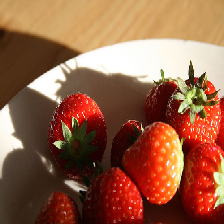

In [11]:
img

# Fine Tuning of a Pre-Trained Model

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
import h5py

In [13]:
def VGG16_FT(weights_path = None, 
             img_width = 224, img_height = 224, 
             f_type = None, n_labels = None ):
    
    """Fine Tuning of a VGG16 based Net"""

    # VGG16 Up to the layer before the last!
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), 
                            input_shape=( 
                            img_width, img_height,3)))

    model.add(Convolution2D(64, 3, 3, activation='relu', 
                            name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', 
                            name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', 
                            name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', 
                            name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', 
                            name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', 
                            name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', 
                            name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', 
                            name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', 
                            name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', 
                            name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', 
                            name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', 
                            name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', 
                            name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())

    # Plugging new Layers
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dropout(0.0))
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dropout(0.0))
    
    last_layer = Dense(n_labels, activation='sigmoid')
    loss = 'categorical_crossentropy'
    optimizer = optimizers.Adam(lr=1e-4, epsilon=1e-08)
    batch_size = 128
    weights_path='/home/ubuntu/deep-learning-keras-tensorflow/deep_learning_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    #model.load_weights(weights_path)
    f = h5py.File(weights_path,'r')
    for k in range(len(f.attrs['layer_names'])):
        weights_layer_name = f.attrs['layer_names'][k].decode("utf-8")

        if not 'conv' in weights_layer_name:
            continue
        g = f[f.attrs['layer_names'][k]]
        weights = [g[g.attrs['weight_names'][p]] 
                   for p in range(len(g.attrs['weight_names']))]
        if k >= len(model.layers):
            break
        else:
            #finding the correct layer in our model (ugly fix)
            weights_model_block = weights_layer_name.split('_')[0][-1]
            weights_model_layer_in_block = weights_layer_name.split('_')[1][-1]
            for model_layer_ind in range(len(model.layers)):
                if 'conv' in model.layers[model_layer_ind].name:
                    cur_model_layer_name = model.layers[model_layer_ind].name
                    
                    our_model_block = cur_model_layer_name.split('_')[0][-1]
                    our_model_layer_in_block = cur_model_layer_name.split('_')[1]
                    
                    if (weights_model_block == our_model_block) and (weights_model_layer_in_block == our_model_layer_in_block):
                        break
                    
            model.layers[model_layer_ind].set_weights(weights)
    f.close()
    print('Model loaded.')

    model.add(last_layer)

    # set the first 25 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:25]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model, batch_size


In [21]:
#loading the model
cifar_model , _ = VGG16_FT(n_labels=10)

Model loaded.


In [22]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
%matplotlib inline

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
img_rows, img_cols = 32, 32
nb_classes = 10

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train,nb_classes)
Y_test = np_utils.to_categorical(y_test,nb_classes)

In [23]:
cifar_model.fit(X_train, Y_train, batch_size=32, 
          nb_epoch=50,verbose=1,
          validation_data=(X_test, Y_test))

Exception: Error when checking model input: expected zeropadding2d_input_2 to have shape (None, 224, 224, 3) but got array with shape (50000, 32, 32, 3)

# Hands On:

### Try to do the same with other models 

In [15]:
#%load deep_learning_models/vgg19.py

In [16]:
#%load deep_learning_models/resnet50.py
